In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as stats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract

Modeling the effect of AcCh and brain region on lipid levels is better done using normalized, species-level data than the previously used group-level data.  Moreover, including a random effect term of samples (mixed effects modeling) seems a beneficial addition.  However, analysis of residuals shows that normal linear models do not fit well in general to the group-level and species-level data.  This calls into question the results inferred previously from a fixed effects linear model fitted on group-level data. Instead, linear models with right-skewed error distribution may provide better fit and hence more credible findings.

## Data sets

The lipid species-level data contains $n_{\mathrm{species} \in \mathrm{group}}$ times more information than the group-level data previously analyzed in the present project.  Therefore, fitting models to species-level data would be advantageous.

| | lipid group-level data | lipid species-level data |
| ------------------------- | ----------- | -------------- |
| a unit of observation | a lipid group in a sample | a lipid species in a sample |
| no. data points per lipid group | $3 \times 10$ samples | $3 \times 10 \times n_{\mathrm{species} \in \mathrm{group}}$ |
| level of $\mathrm{species} \in \mathrm{group}$ assumed i.i.d? (linear model) | yes | yes |


In [2]:
fpath = '../../resources/demographic-data.csv'
demographic_data = pd.read_csv(fpath, index_col=0)

In [3]:
brain_regions = ['DLPFC', 'CN', 'Putamen']
brain_regions1 = ['CN', 'Putamen', 'DLPFC']

In [4]:
def to_long_format(wide_data, axis_names=['Group', 'Species', 'Region', 'Subject'], demographic_data=demographic_data):
    s = wide_data.stack(level=1).stack().rename_axis(axis_names)
    endog = s.to_frame('Level')
    exog = s.index.to_frame()
    exog['Region:Subject'] = [r + ' : ' + s for r, s in zip(exog.Region, exog.Subject)]
    exog['Dx'] = [re.sub('^(Control|ChAc).*$', '\\1', s) for s in exog.Subject]
    data = pd.concat([endog, exog], axis=1)
    data = data.astype({
        'Region': CategoricalDtype(categories=brain_regions, ordered=True),
        'Dx': CategoricalDtype(categories=['Control', 'ChAc'], ordered=True),
                       })
    demdata = demographic_data.reindex(data.index.get_level_values('Subject'))
    demdata.index = data.index
    data = pd.concat([data, demdata], axis=1)
    return(data)

In [5]:
fpath = '../../resources/lipid-data-groups.csv'
lipid_groups = pd.read_csv(fpath, header=[0, 1], index_col=0)
lipid_groups = lipid_groups.reindex(pd.MultiIndex.from_product([demographic_data.index, brain_regions]), axis=1)
std_lipid_groups = lipid_groups.apply(lambda s: (s - s.mean()) / s.std(), axis=1)
stdgroupdata = to_long_format(std_lipid_groups, ['Group', 'Region', 'Subject'])
stdgroupdata

Level Group   Region    Subject  \
Group Region  Subject                                         
FC    CN      ChAc 1    -0.520661    FC       CN     ChAc 1   
              ChAc 2    -2.466412    FC       CN     ChAc 2   
              ChAc 3     1.146440    FC       CN     ChAc 3   
              ChAc 4     1.268065    FC       CN     ChAc 4   
              Control 1  1.302206    FC       CN  Control 1   
...                           ...   ...      ...        ...   
NSer  Putamen Control 2  0.443121  NSer  Putamen  Control 2   
              Control 3 -0.351664  NSer  Putamen  Control 3   
              Control 4  0.521406  NSer  Putamen  Control 4   
              Control 5  0.080771  NSer  Putamen  Control 5   
              Control 6 -0.666297  NSer  Putamen  Control 6   

                              Region:Subject       Dx  AgeAtDeath  
Group Region  Subject                                              
FC    CN      ChAc 1             CN : ChAc 1     ChAc          51  
              ChAc 2             CN : ChAc 2     ChAc          50  
              ChAc 3             CN : ChAc 3     ChAc          61  
              ChAc 4             CN : ChAc 4     ChAc          40  
              Control 1       CN : Control 1  Control          53  
...                                      ...      ...         ...  
NSer  Putamen Control 2  Putamen : Control 2  Control          50  
              Control 3  Putamen : Control 3  Control          57  
              Control 4  Putamen : Control 4  Control          59  
              Control 5  Putamen : Control 5  Control          54  
              Control 6  Putamen : Control 6  Control          59  

[1020 rows x 7 columns]

In [6]:
fpath = '../../resources/lipid-data-species-normalized-pretty.csv'
norm_lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
fpath = '../../resources/lipid-data-species-pretty.csv'
lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
std_lipid_species = lipid_species.apply(lambda s: (s - s.mean()) / s.std(), axis=1)

In [7]:
data = to_long_format(lipid_species)
normdata = to_long_format(norm_lipid_species)
stddata = to_long_format(std_lipid_species)
data

Level Group     Species   Region  \
Group Species    Region  Subject                                          
FC    FC         CN      ChAc 1     74.76526    FC          FC       CN   
                         ChAc 2     62.75982    FC          FC       CN   
                         ChAc 3     85.05140    FC          FC       CN   
                         ChAc 4     85.80184    FC          FC       CN   
                         Control 1  86.01249    FC          FC       CN   
...                                      ...   ...         ...      ...   
NSer  NSer 22:6  Putamen Control 2   0.00024  NSer  NSer 22:6   Putamen   
                         Control 3   0.00074  NSer  NSer 22:6   Putamen   
                         Control 4   0.00008  NSer  NSer 22:6   Putamen   
                         Control 5   0.00034  NSer  NSer 22:6   Putamen   
                         Control 6   0.00042  NSer  NSer 22:6   Putamen   

                                      Subject       Region:Subject       Dx  \
Group Species    Region  Subject                                              
FC    FC         CN      ChAc 1        ChAc 1          CN : ChAc 1     ChAc   
                         ChAc 2        ChAc 2          CN : ChAc 2     ChAc   
                         ChAc 3        ChAc 3          CN : ChAc 3     ChAc   
                         ChAc 4        ChAc 4          CN : ChAc 4     ChAc   
                         Control 1  Control 1       CN : Control 1  Control   
...                                       ...                  ...      ...   
NSer  NSer 22:6  Putamen Control 2  Control 2  Putamen : Control 2  Control   
                         Control 3  Control 3  Putamen : Control 3  Control   
                         Control 4  Control 4  Putamen : Control 4  Control   
                         Control 5  Control 5  Putamen : Control 5  Control   
                         Control 6  Control 6  Putamen : Control 6  Control   

                                    AgeAtDeath  
Group Species    Region  Subject                
FC    FC         CN      ChAc 1             51  
                         ChAc 2             50  
                         ChAc 3             61  
                         ChAc 4             40  
                         Control 1          53  
...                                        ...  
NSer  NSer 22:6  Putamen Control 2          50  
                         Control 3          57  
                         Control 4          59  
                         Control 5          54  
                         Control 6          59  

[17790 rows x 8 columns]

## "Identical distribution" assumption violated

Here I inspect whether unnormalized data might be amenable for fitting regression models.  The heatmaps show that some lipid species within a lipid group have much higher levels across all or most samples than the rest of the species.

In other words: the levels of lipid species in a group are not identically distributed.  This finding has the following implies:

1. In the group-level data some lipid species in a given group have larger weight than other species in that group.  (I assume that each group-level value was obtained by summing the levels of all species in that group.)
1. The species-level data must be normalized across samples to satisfy the identical distribution assumption.

In [8]:
def heatmap(group, is_normalized, y=0.98):
    data = norm_lipid_species if is_normalized else lipid_species
    fig, ax = plt.subplots(1, 3, sharey=True)
    for ix, region in enumerate(brain_regions):
        d = data.xs(group, axis=0, level=0)
        vmin = d.min().min()
        vmax = d.max().max()
        d = d.xs(region, axis=1, level=1)
        ax[ix].imshow(d, interpolation='none', vmin=vmin, vmax=vmax)
        ax[ix].set_title(region)
        ax[ix].set_yticks(range(len(d)))
        ax[ix].set_yticklabels(d.index)
        prefix = 'Normalized' if is_normalized else 'Raw'
        fig.suptitle(prefix + ' ' + group + ' levels', fontsize=14, y=y)
    return((fig, ax))

### Lipid group: BMP

['named-figure/raw-BMP-levels.png', 'named-figure/raw-BMP-levels.pdf']

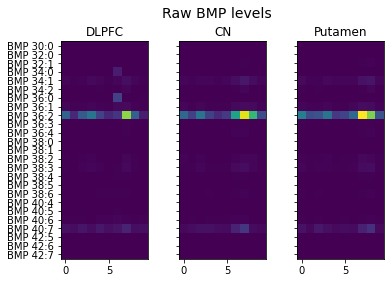

In [9]:
fig, ax = heatmap('BMP', is_normalized=False, y=1)
attila_utils.savefig(fig, 'raw-BMP-levels')

['named-figure/norm-BMP-levels.png', 'named-figure/norm-BMP-levels.pdf']

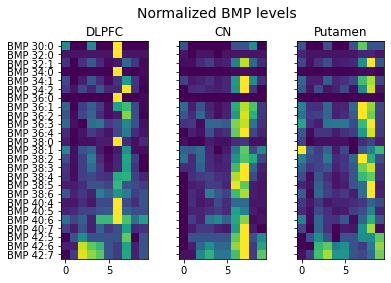

In [10]:
fig, ax = heatmap('BMP', is_normalized=True, y=1)
attila_utils.savefig(fig, 'norm-BMP-levels')

### Lipid group: Sulf

['named-figure/raw-Sulf-levels.png', 'named-figure/raw-Sulf-levels.pdf']

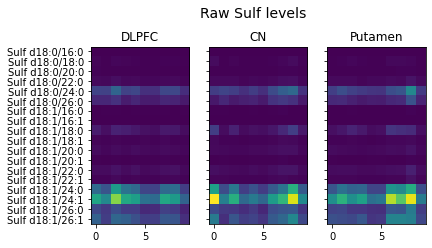

In [11]:
fig, ax = heatmap('Sulf', is_normalized=False, y=0.95)
attila_utils.savefig(fig, 'raw-Sulf-levels')

['named-figure/norm-Sulf-levels.png', 'named-figure/norm-Sulf-levels.pdf']

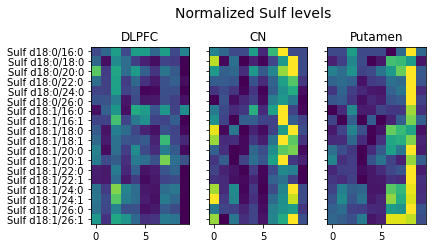

In [12]:
fig, ax = heatmap('Sulf', is_normalized=True, y=0.95)
attila_utils.savefig(fig, 'norm-Sulf-levels')

### Lipid group: PCe

['named-figure/raw-PCe-levels.png', 'named-figure/raw-PCe-levels.pdf']

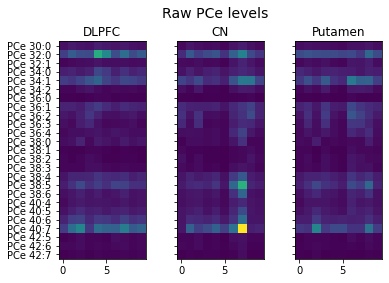

In [13]:
fig, ax = heatmap('PCe', is_normalized=False, y=1)
attila_utils.savefig(fig, 'raw-PCe-levels')

['named-figure/norm-PCe-levels.png', 'named-figure/norm-PCe-levels.pdf']

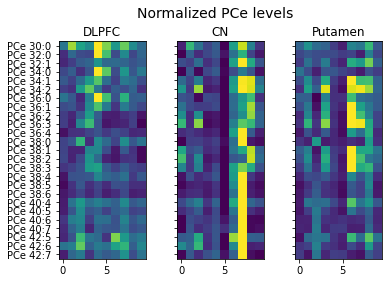

In [14]:
fig, ax = heatmap('PCe', is_normalized=True, y=1)
attila_utils.savefig(fig, 'norm-PCe-levels')

### Lipid group: LPS

['named-figure/raw-LPS-levels.png', 'named-figure/raw-LPS-levels.pdf']

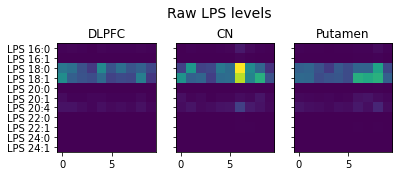

In [15]:
fig, ax = heatmap('LPS', is_normalized=False, y=0.82)
attila_utils.savefig(fig, 'raw-LPS-levels')

['named-figure/norm-LPS-levels.png', 'named-figure/norm-LPS-levels.pdf']

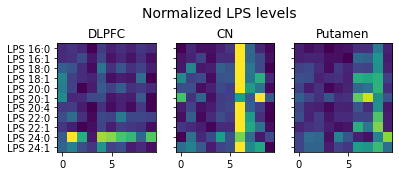

In [16]:
fig, ax = heatmap('LPS', is_normalized=True, y=0.82)
attila_utils.savefig(fig, 'norm-LPS-levels')

## Visualizing changes

['named-figure/line-ensemble.png', 'named-figure/line-ensemble.pdf']

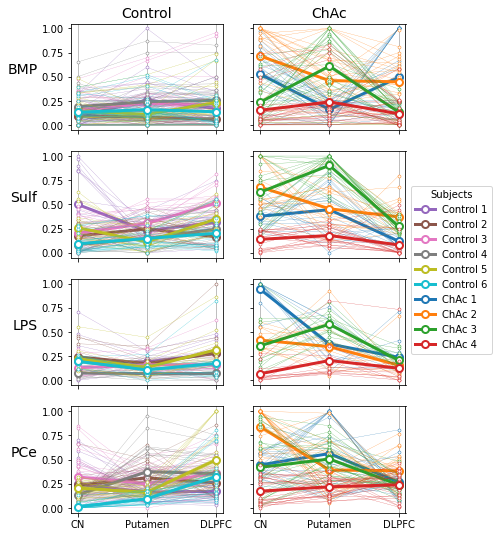

In [17]:
sel_css4_names = ['mediumpurple', 'indigo', 'violet', 'purple', 'darkolivegreen', 'darkseagreen', 'forestgreen', 'limegreen', 'darkgreen', 'lime']
sel_css4 = {k: mcolors.CSS4_COLORS[k] for k in sel_css4_names}

def line_ensemble(ax, group='BMP', Dx='ChAc', norm_lipid_species=norm_lipid_species, setlabel=False, colordict=mcolors.TABLEAU_COLORS, plot_species=True):
    lgroup_levels = norm_lipid_species.xs(group, level=0, axis=0)
    nsubj = 4 if Dx == 'ChAc' else 6
    subject_names = [Dx + ' ' + str(i + 1) for i in range(nsubj)]
    offset = 0 if Dx == 'ChAc' else 4
    colors = list(colordict.values())[offset + 0: nsubj + offset]
    for subj, col in zip(subject_names, colors):
        d = lgroup_levels.xs(subj, level=0, axis=1)
        for spec in d.index:
            if plot_species:
                ax.plot(d.loc[spec], color=col, marker='o', markerfacecolor='white', markersize=3, markeredgewidth=0.5, linewidth=0.2)
        ax.plot(d.mean(), color=col, linewidth=3, marker='o', markerfacecolor='white', markersize=7, markeredgewidth=2, label=subj if setlabel else None)
        ax.grid(axis='x')
    if Dx == 'Control':
        ax.set_ylabel(group, y=0.5, rotation=0, horizontalalignment='right', fontsize=14)
    #ax.set_title(Dx)
    ax.grid(axis='x')
    return(ax)

def line_ensemble_main(colordict, plot_species, sel_groups=['BMP', 'Sulf', 'LPS', 'PCe']):
    fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(6, 9))
    for i, group in enumerate(sel_groups):
        setlabel = True if i == 0 else None
        line_ensemble(ax[i, 0], group, 'Control', setlabel=setlabel, colordict=colordict, plot_species=plot_species)
        line_ensemble(ax[i, 1], group, 'ChAc', setlabel=setlabel, colordict=colordict, plot_species=plot_species)
    ax[0, 0].set_title('Control', fontsize=14)
    ax[0, 1].set_title('ChAc', fontsize=14)
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Subjects')
    return((fig, ax))

fig, ax = line_ensemble_main(mcolors.TABLEAU_COLORS, plot_species=True)
attila_utils.savefig(fig, 'line-ensemble')

['named-figure/line-ensemble-green-purple.png',
 'named-figure/line-ensemble-green-purple.pdf']

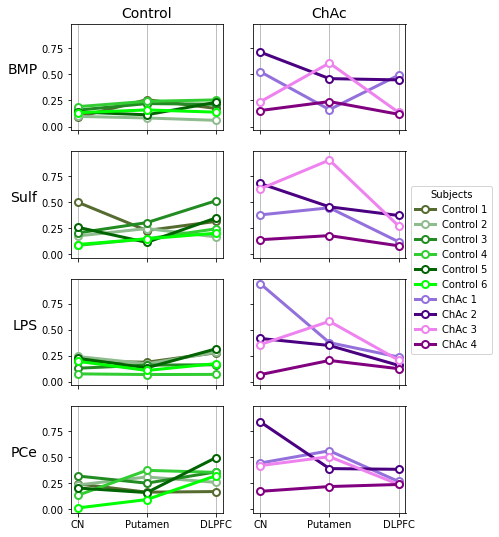

In [18]:
fig, ax = line_ensemble_main(sel_css4, plot_species=False)
attila_utils.savefig(fig, 'line-ensemble-green-purple')

<AxesSubplot:>

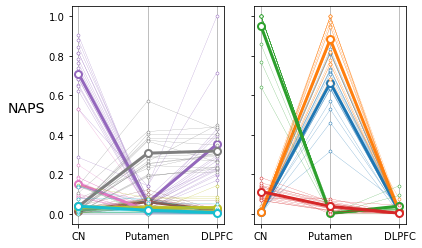

In [19]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
line_ensemble(ax[0], 'NAPS', 'Control')
line_ensemble(ax[1], 'NAPS', 'ChAc')

<AxesSubplot:>

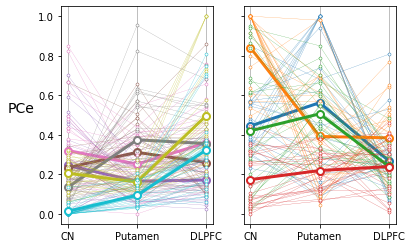

In [20]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
line_ensemble(ax[0], 'PCe', 'Control')
line_ensemble(ax[1], 'PCe', 'ChAc')

<AxesSubplot:>

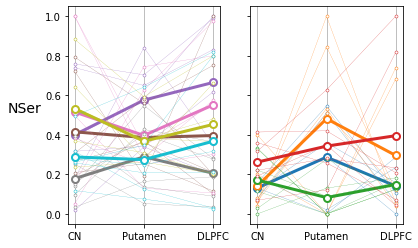

In [21]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
line_ensemble(ax[0], 'NSer', 'Control')
line_ensemble(ax[1], 'NSer', 'ChAc')

## Fitting linear fixed and mixed models

### Group-level data
Let's take the group-level data $Y'_g, X'_g$ for lipid group $g$!  Then the lipid level $y'_{gi}$ of group $g$ and the $i$th sample can be modeled with a fixed effects linear model such as
$$
\begin{equation}
y'_{gi} = \beta'_{0, g} + \beta'_{\mathrm{Dx}, g} x'_{\mathrm{Dx}, i} + \beta'_{\mathrm{Region}, g} x'_{\mathrm{Region}, i} + \beta'_{\mathrm{Dx}:\mathrm{Region}, g} x'_{\mathrm{Dx}, i} x'_{\mathrm{Region}, i} + \epsilon'_{gi}
\end{equation}
$$

Or the data can be modeled with a mixed effects linear model, which has an additional, random effects term $\gamma_i$ relative to the fixed effects terms of the previous model (denoted by $...$)
$$
\begin{equation}
y'_{gi} = ... + \gamma'_{gi} + \epsilon'_{gi},
\end{equation}
$$
where $\gamma_i$ is a random parameter and $\gamma_i = \gamma_j$ if sample $i$ and $j$ both come from the same individual.

### Species-level data
Now let's turn to the (normalized) species-level data $Y_g, X_g$!  The $y_{s\in gi}$ lipid level of species $s\in g$ and the $i$th sample may be modeled as
$$
\begin{equation}
y_{s\in gi} = \beta_{0, g} + \beta_{\mathrm{Dx}, g} x_{\mathrm{Dx}, i} + \beta_{\mathrm{Region}, g} x_{\mathrm{Region}, i} + \beta_{\mathrm{Dx}:\mathrm{Region}, g} x_{\mathrm{Dx}, i} x_{\mathrm{Region}, i} + \epsilon_{s\in gi}
\end{equation}
$$

The mixed effects version similar to the group-level model is:
$$
\begin{equation}
y_{s\in gi} = ... + \gamma_{s\in gi} + \epsilon_{s\in gi},
\end{equation}
$$

### Regression formulas
All four models are expressed with the `Level ~ 1 + Dx + Region + Dx:Region` formula.  The notation and interpretation of possible terms is in the following table

| Term | Interpretation |
|---|---|
| Level | level of lipid, response/endogenous variable |
| 1 | intercept, mean level |
| Region | uniform effect of brain region across all Control and ChAc samples |
| Dx | uniform effect of ChAc level across regions |
| Dx:Region | differential effect of ChAc across regions |
| AgeAtDeath | uniform effect of age at death across all regions and in both Control and ChAc |
| ($\gamma_{s\in gi}$) | random effect of sample and lipid-group |


In [22]:
def extract_group(group, df=data):
    val = df.xs(group, axis=0, level='Group')
    return(val)

def fit_to_group(formula, group, effects='mixed', df=stddata):
    d = extract_group(group, df)
    if effects == 'mixed':
        md = smf.mixedlm(formula, data=d, groups='Subject')
        # Random effect of the Region:Subject was tested but is not used here
        #  as it decreases the power of testing the Dx:Region fixed effect.
        #md = smf.mixedlm(formula, data=d, groups='Region:Subject') 
    if effects == 'fixed':
        md = smf.ols(formula, data=d)
    mdf = md.fit()
    return(mdf)

### Models of increasing complexity

More complex models fit the same data in general at least as well, if not better, as (nested) less complex models.  Too complex models, however, tend to overfit the data and the parameter estimates become unstable.

In [23]:
formulas = ['Level ~ 1', 'Level ~ 1 + Dx', 'Level ~ 1 + Region', 'Level ~ 1 + Dx:Region', 'Level ~ 1 + Dx:Region + AgeAtDeath', 'Level ~ 1 + Dx + Dx:Region', 'Level ~ 1 + Dx + Region + Dx:Region']
#sel_groups = ['BMP', 'Sulf', 'PG']

In [24]:
def fit_all_models_to_group(group, formulas, stddata=stddata, do_mixed=False):
    effects = ['fixed', 'mixed'] if do_mixed else ['fixed']
    l = [[fit_to_group(f, group, fx, df=stddata) for f in formulas] for fx in effects]
    ix = pd.MultiIndex.from_product([effects, formulas])
    res = pd.DataFrame({group: itertools.chain(*l)}, index=ix)
    return(res)

fitted_models = pd.concat([fit_all_models_to_group(group, formulas, do_mixed=True) for group in lipid_groups.index], axis=1)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optim

In [25]:
fitted_groupmodels = pd.concat([fit_all_models_to_group(group, formulas, stddata=stdgroupdata, do_mixed=True) for group in lipid_groups.index], axis=1)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Inference using various models

I inspect models here whose formula is:

> Level ~ 1 + Dx:Region + AgeAtDeath

The goals of this section: compare inferred effects and their significance across...
1. group-level and species-level data
1. the presence and absence of random sample effects

### Differential effect of ChAc across regions

Of perhaps the most important biomedical interest is the differential effect of ChAc across regions.  The conclusions from the following analyses are:
1. inference from species-level data is qualitatively consistent with that from group-level data
1. quantitatively viewing it, inference from species-level data yields smaller estimated false negative errors (i.e yields lower $p$-values)
1. the mixed effects flavor gives somewhat greater estimated false negative errors than the fixed effects one

In [26]:
fittedm = {'group-level data': fitted_groupmodels, 'species-level data': fitted_models}

def extract_property(fun, formula='Level ~ 1 + Dx:Region + AgeAtDeath', fittedm=fittedm):
    def helper(dataset='group-level data'):
        df = fittedm[dataset].xs(formula, level=1, axis=0)
        effects = np.unique(df.index.get_level_values(0))
        res = pd.concat([df.loc[fx].apply(fun) for fx in effects], axis=1)
        res.columns = pd.MultiIndex.from_product([[dataset], effects])
        return(res)
    l = [helper(ds) for ds in fittedm.keys()]
    res = pd.concat(l, axis=1)
    return(res)

fun = lambda m: m.tvalues.loc['Dx[T.ChAc]:Region[CN]']
tvalues = extract_property(fun)
#tvalues

['named-figure/t-value-heatmap-fixed-mixed-models.png',
 'named-figure/t-value-heatmap-fixed-mixed-models.pdf']

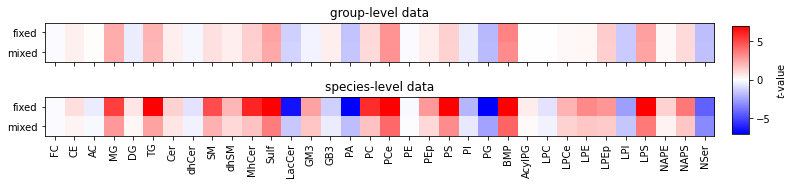

In [27]:
def imshow_extracted(extracted, cb_label, cmap='bwr', autoscale=True, vmin=-1, vmax=1):
    fig, ax = plt.subplots(2, 1, figsize=(12, 2.5), sharex=True)
    datasets = extracted.xs('fixed', level=1, axis=1).columns
    vmin = extracted.min(axis=0).min() if autoscale else vmin
    vmax = extracted.max(axis=0).max() if autoscale else vmax
    for axi, dset in zip(ax, datasets):
        df = extracted.xs(dset, level=0, axis=1)
        axi.imshow(df.transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
        axi.set_title(dset)
        axi.set_yticks(range(df.shape[1]))
        axi.set_yticklabels(df.columns)
        axi.set_xticks(range(df.shape[0]))
        axi.set_xticklabels(df.index, rotation=90)
    cm = plt.cm.ScalarMappable(cmap=cmap)
    cm.set_clim(vmin=vmin, vmax=vmax)
    cb_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(cm, cax=cb_ax, label=cb_label)
    #fig.suptitle(suptitle, fontsize=14)
    return((fig, ax))

fig, ax = imshow_extracted(tvalues, r'$t$-value', autoscale=False, vmin=-7, vmax=7)
attila_utils.savefig(fig, 't-value-heatmap-fixed-mixed-models')

In [28]:
fun = lambda m: np.log10(m.pvalues.loc['Dx[T.ChAc]:Region[CN]'])
pvalues_CN = extract_property(fun)
pvalues_CN

group-level data           species-level data          
                  fixed     mixed              fixed     mixed
FC            -0.048671 -0.049027          -0.048671 -0.049027
CE            -0.175955 -0.176721          -0.431813 -0.124965
AC            -0.034746 -0.032234          -0.227108 -0.079901
MG            -1.501381 -1.657181          -6.720306 -2.338991
DG            -0.216861 -0.212547          -0.320543 -0.098258
TG            -1.287209 -1.355383         -32.362906 -1.975061
Cer           -0.185721 -0.181233          -0.677482 -0.305968
dhCer         -0.090720 -0.088790          -0.338168 -0.151138
SM            -0.398124 -0.403135          -5.796179 -1.497441
dhSM          -0.194039 -0.195937          -1.344562 -0.558694
MhCer         -0.713230 -0.705567          -8.448055 -1.021665
Sulf          -1.703806 -1.775709         -21.386973 -3.439584
LacCer        -0.657899 -0.639640          -9.694953 -0.855058
GM3           -0.111419 -0.111379          -1.919110 -0.938699
GB3           -0.180312 -0.181086          -0.703292 -0.217426
PA            -0.926912 -0.902648         -14.567620 -1.144945
PC            -0.518934 -0.521737          -7.953299 -1.039117
PCe           -2.198783 -2.481341         -26.650424 -4.460117
PE            -0.042609 -0.043081          -0.063510 -0.022388
PEp           -0.214410 -0.216883          -2.306503 -0.557441
PS            -0.659863 -0.676017         -12.363253 -2.740264
PI            -0.218818 -0.216886          -1.342086 -0.269275
PG            -1.174094 -1.206654         -17.020113 -1.894279
BMP           -2.599015 -2.771600         -22.719128 -4.684856
AcylPG        -0.009826 -0.009189          -0.227488 -0.051365
LPC           -0.002090 -0.002094          -0.339785 -0.136884
LPCe          -0.068208 -0.068530          -1.395529 -0.646577
LPE           -0.093990 -0.093257          -2.866131 -0.945390
LPEp          -0.759838 -0.739483          -2.348753 -0.834568
LPI           -0.792928 -0.814803          -2.102984 -0.918299
LPS           -1.767139 -1.868033         -14.240931 -3.553238
NAPE          -0.066198 -0.062091          -0.640411 -0.129368
NAPS          -0.506393 -0.521638          -3.597870 -0.919871
NSer          -1.050784 -1.078044          -4.487722 -2.861848

['named-figure/p-value-heatmap-fixed-mixed-models.png',
 'named-figure/p-value-heatmap-fixed-mixed-models.pdf']

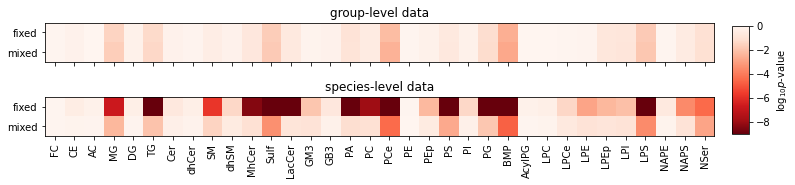

In [29]:
fig, ax = imshow_extracted(pvalues_CN, r'$\log_{10}p$-value', cmap='Reds_r', autoscale=False, vmin=-9, vmax=0)
attila_utils.savefig(fig, 'p-value-heatmap-fixed-mixed-models')

## Volcano plots

In [30]:
l = [extract_property(lambda m: m.pvalues.loc['Dx[T.ChAc]:Region[' + r +']'])[('species-level data', 'mixed')] for r in brain_regions1]
pvalues = pd.concat(l, axis=1)
pvalues.columns = brain_regions1
log10pvalues = pvalues.applymap(np.log10)


Multiple hypothesis correction

In [31]:
pvalues_long = pvalues.unstack()
reject_long, pvals_corrected_long, alphacSidak, alphacBonf = sm.stats.multipletests(pvalues_long, method='fdr_bh')

Fold changes

In [32]:
def get_fold_change(group, region, data=data):
    df = data.xs(group, level='Group', axis=0).xs(region, level='Region', axis=0)
    Control = df.loc[df.Dx == 'Control']
    ChAc = df.loc[df.Dx == 'ChAc']
    fc = ChAc.Level.mean() / Control.Level.mean()
    return(fc)

a = np.array([[get_fold_change(g, r) for r in brain_regions1] for g in lipid_groups.index])
fold_changes = pd.DataFrame(a, index=lipid_groups.index, columns=brain_regions1)
log2fold_changes = fold_changes.applymap(np.log2)
#log2fold_changes

Color vectors for volcano plots

In [33]:
def unstack_corrected(a, index=pvalues_long.index):
    s = pd.Series(a, index=index)
    df = s.unstack(level=0)
    return(df)

def make_colorvec(palette=['red', 'blue', 'gray'], reject_long=reject_long, fold_changes=fold_changes):
    colorvec_long = [(lambda x: palette[0] if x else palette[2])(b) for b in reject_long]
    colorvec_long = [c if f >= 1 or c == palette[2] else palette[1] for c, f in zip(colorvec_long, fold_changes.unstack())]
    colorvec = unstack_corrected(colorvec_long)
    return(colorvec)

edgecolors = make_colorvec(palette=['red', 'blue', 'gray'])
facecolors = make_colorvec(palette=['pink', 'lightblue', 'lightgray'])

Text vectors for volcano plots

In [34]:
textvec = edgecolors.apply(lambda s: s.index, axis=0)
textvec_long = [t if r else '' for t, r in zip(textvec.unstack(), reject_long)]
textvec = unstack_corrected(textvec_long)

['named-figure/volcano-plot-ChAc-Region.png',
 'named-figure/volcano-plot-ChAc-Region.pdf']

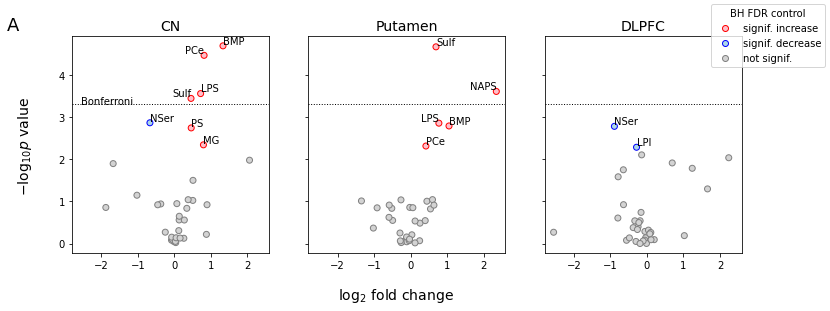

In [35]:
fig, ax = plt.subplots(1, len(brain_regions1), sharey=True, sharex=True, figsize=(12, 4))
horizontalalignment_region = {'CN': {'PCe': 'right', 'Sulf': 'right'}, 'Putamen': {'LPS': 'right', 'NAPS': 'right'}}
for axi, r in zip(ax, brain_regions1):
    axi.scatter(x=log2fold_changes[r], y=-log10pvalues[r], edgecolors=edgecolors[r], marker='o', facecolors=facecolors[r])
    for x, y, s in zip(log2fold_changes[r], -log10pvalues[r], textvec[r]):
        if r in horizontalalignment_region.keys():
            change_alignment = s in horizontalalignment_region[r].keys()
        else:
            change_alignment = False
        horizontalalignment = horizontalalignment_region[r][s] if change_alignment else 'left'
        axi.text(x=x, y=y, s=s, verticalalignment='bottom', horizontalalignment=horizontalalignment)
    bonf_y = -np.log10(alphacBonf)
    axi.axhline(y=bonf_y, linestyle='dotted', color='black', linewidth=1)
    if r == 'CN':
        axi.text(x=log2fold_changes.min(axis=0).min(), y=bonf_y, s=r'Bonferroni')
    axi.set_title(r, fontsize=14)
    #axi.set_xlabel(r'$\log_2$ fold change')
    #axi.set_ylabel(r'$\log_{10}p$ value')

def line2d_legend(markeredgecolor='red', markerfacecolor='pink', label='signif. increase'):
    line = Line2D([0, 1], [0, 0], linewidth=0, markeredgecolor=markeredgecolor, markerfacecolor=markerfacecolor, label=label, marker='o')
    return(line)

fig.legend(handles=[line2d_legend('red', 'pink', 'signif. increase'),
                    line2d_legend('blue', 'lightblue', 'signif. decrease'),
                    line2d_legend('gray', 'lightgray', 'not signif.'),
                   ], title='BH FDR control')
fig.supxlabel(r'$\log_2$ fold change', y=-0.05, fontsize=14)
fig.supylabel(r'$-\log_{10}p$ value', x=0.06, fontsize=14)
fig.text(0.05, 0.9, 'A', fontsize=18)
attila_utils.savefig(fig, 'volcano-plot-ChAc-Region')

## Tables

Extract parameter estimates and associated $p$-values

In [36]:
def extract_vector_property(fun, effects='mixed', formula='Level ~ 1 + Dx:Region + AgeAtDeath', fittedm=fitted_models):
    s = fittedm.loc[(effects, formula)]
    df = s.apply(fun)
    return(df)

pars = extract_vector_property(lambda x: x.params)
pvals = extract_vector_property(lambda x: x.pvalues)
parest = pd.concat([pars, pvals], axis=1, keys=['estimate', 'p-value'])
parest = parest.swaplevel(i=-2, j=-1, axis=1)
parest = parest.reindex(pd.MultiIndex.from_product([pars.columns, ['estimate', 'p-value']]), axis=1)
fpath = '../../results/2022-09-04-mixed-models/supplementary-tables.xlsx'
with pd.ExcelWriter(fpath) as writer:
    lipid_species.to_excel(writer, sheet_name='Table S1 Lipid levels')
    parest.to_excel(writer, sheet_name='Table S2 Inferred effects')

In [37]:
l = [extract_property(lambda m: m.pvalues.loc['Region[T.' + r +']'])[('species-level data', 'mixed')] for r in brain_regions1[:-1]]
pvalues_region = pd.concat(l, axis=1)
pvalues_region.columns = brain_regions1[:-1]
pvalues_long_region = pvalues_region.unstack()
reject_long_region, pvals_corrected_long_region, alphacSidak_region, alphacBonf_region = sm.stats.multipletests(pvalues_long_region, method='fdr_bh')
reject_region = unstack_corrected(reject_long_region, index=pvalues_long_region.index)
reject = unstack_corrected(reject_long)
fpath = '../../results/2022-09-04-mixed-models/table1-fdr-reject.xlsx'
with pd.ExcelWriter(fpath) as writer:
    pd.concat([reject, reject_region], axis=1).to_excel(writer)

## Estimates and errors

['named-figure/dx-region-estimates.png',
 'named-figure/dx-region-estimates.pdf']

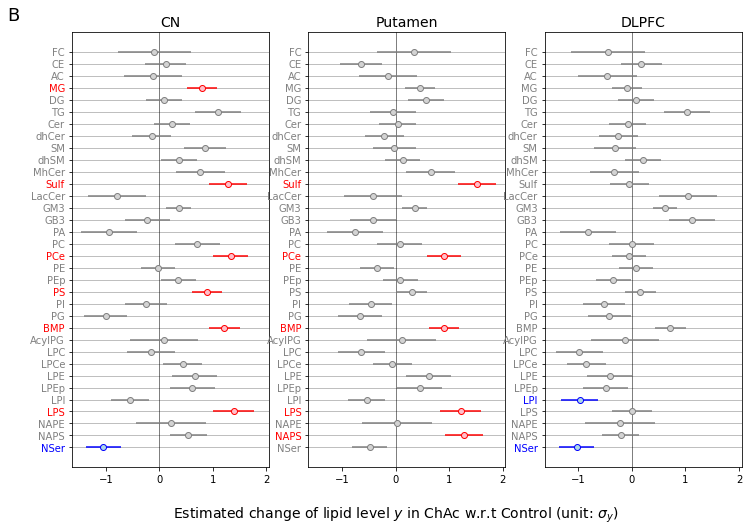

In [38]:
bse = extract_vector_property(lambda x: x.bse)
fig, ax = plt.subplots(1, len(brain_regions1), sharey=False, sharex=True, figsize=(12, 8))
revticks = pd.Series(np.arange(pars.shape[0], 0, -1) - 1, index=pars.index)
fwticks = pd.Series(range(pars.shape[0]), index=pars.index)
for r, axi in zip(brain_regions1, ax):
    axi.set_title(r, fontsize=14)
    axi.axvline(0, linestyle='solid', color='black', linewidth=0.5)
    axi.grid(axis='y')
    axi.set_yticks(revticks)
    axi.set_yticklabels(revticks.index)
    col = 'Dx[T.ChAc]:Region[' + r +']'
    def plot_significance_set(boolv=~reject[r], markeredgecolor='gray', markerfacecolor='lightgray'):
        y = revticks.loc[boolv]
        x_pars = pars.loc[boolv, col]
        xerr = bse.loc[boolv, col]
        axi.errorbar(x=x_pars, y=y, xerr=xerr, linestyle='none', ecolor=markeredgecolor, markeredgecolor=markeredgecolor, markerfacecolor=markerfacecolor, marker='o')
        for ix in fwticks[boolv]:
            axi.get_yticklabels()[ix].set_color(markeredgecolor)
        return(y)
    plot_significance_set(boolv=~reject[r], markeredgecolor='gray', markerfacecolor='lightgray')
    plot_significance_set(boolv=reject[r] & (pars[col] > 0), markeredgecolor='red', markerfacecolor='pink')
    y = plot_significance_set(boolv=reject[r] & (pars[col] < 0), markeredgecolor='blue', markerfacecolor='lightblue')
fig.supxlabel(r'Estimated change of lipid level $y$ in ChAc w.r.t Control (unit: $\sigma_y$)', y=0.025, fontsize=14)
fig.text(0.05, 0.9, 'B', fontsize=18)
attila_utils.savefig(fig, 'dx-region-estimates')

## Goodness of fit: Jarque-Bera test

Here I perform the [Jarque-Bera goodness of fit test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test), which assesses whether the normality assumption of linear modeling holds.  The test results show that
1. the assumption is violated for many data sets and models
1. adding the random effects of individuals improves fit
1. the adding the Dx:Region interaction term substantially improves the fit
1. normality is rejected less confidently (at a greater $p$-value) in the group-level data than in the species-level data

The last point is not surprising when we recall that the group-level data contains fewer points than the species-level data.


In [39]:
#fitted_models.applymap(lambda m: sms.jarque_bera(m.resid)[1])

In [40]:
#fitted_groupmodels.applymap(lambda m: sms.jarque_bera(m.resid)[1])

In [41]:
def imshow_model_property(ax, fun, effects='fixed', vmin=-6, vmax=0,
                          cmap='RdYlGn', fitted_models=fitted_models,
                          cb_label=r'$- \log_{10}p$-value', suptitle='Goodness of fit:  Jarque-Bera test'):
    data = fitted_models.xs(effects, level=0, axis=0)
    image = data.applymap(fun)
    ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title('Linear ' + effects + ' effects models')
    ax.set_xticks(range(data.shape[1]))
    ax.set_xticklabels(data.columns, rotation=90)
    ax.set_yticks(range(data.shape[0]))
    ax.set_yticklabels(data.index)
    cm = plt.cm.ScalarMappable(cmap=cmap)
    cm.set_clim(vmin=vmin, vmax=vmax)
    cb_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(cm, cax=cb_ax, label=cb_label)
    fig.suptitle(suptitle, fontsize=14)
    return(ax)

['named-figure/jarque-bera-goodness-of-fit-pval-group-level.png',
 'named-figure/jarque-bera-goodness-of-fit-pval-group-level.pdf']

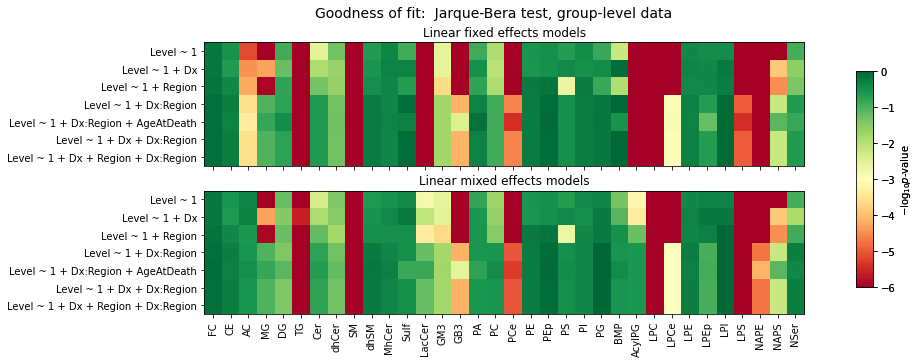

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
suptitle = 'Goodness of fit:  Jarque-Bera test, group-level data'
imshow_model_property(ax[0], fun, 'fixed', suptitle=suptitle, vmin=-6, fitted_models=fitted_groupmodels)
imshow_model_property(ax[1], fun, 'mixed', suptitle=suptitle, vmin=-6, fitted_models=fitted_groupmodels)
attila_utils.savefig(fig, 'jarque-bera-goodness-of-fit-pval-group-level')

<ipython-input-43-aaa760f6f5e8>:2: RuntimeWarning: divide by zero encountered in log10
  fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])


['named-figure/jarque-bera-goodness-of-fit-pval-species-level.png',
 'named-figure/jarque-bera-goodness-of-fit-pval-species-level.pdf']

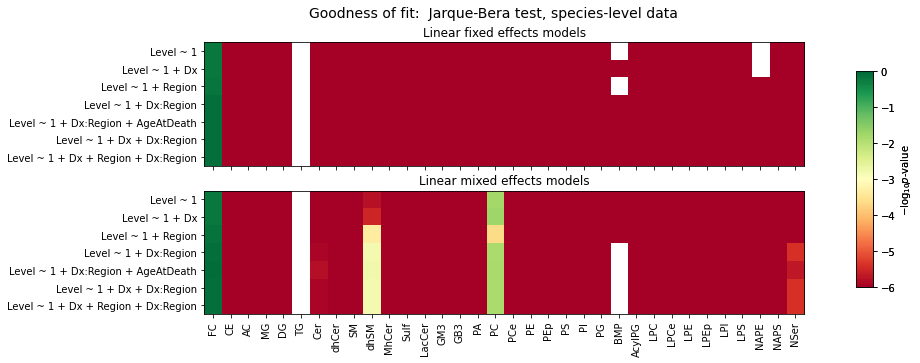

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
suptitle = 'Goodness of fit:  Jarque-Bera test, species-level data'
imshow_model_property(ax[0], fun, 'fixed', suptitle=suptitle, vmin=-6)
imshow_model_property(ax[1], fun, 'mixed', suptitle=suptitle, vmin=-6)
attila_utils.savefig(fig, 'jarque-bera-goodness-of-fit-pval-species-level')

['named-figure/jarque-bera-goodness-of-fit-pval-vs-total-lipid-level.png',
 'named-figure/jarque-bera-goodness-of-fit-pval-vs-total-lipid-level.pdf']

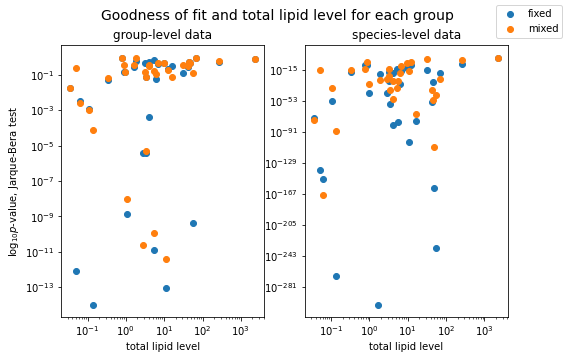

In [44]:
def total_level_vs_jb_pval(ax, fitted=fitted_groupmodels, formula='Level ~ 1 + Dx:Region + AgeAtDeath', do_label=True):
    fun = lambda m: sms.jarque_bera(m.resid)[1]
    df = fitted.xs(formula, level=1, axis=0).applymap(fun)
    effects = effects = np.unique(df.index.get_level_values(0))
    [ax.scatter(x=lipid_groups.sum(axis=1), y=df.loc[fx], marker='o', label=fx if do_label else None) for fx in effects]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('total lipid level')
    

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
total_level_vs_jb_pval(ax[0], fitted=fitted_groupmodels, do_label=False)
ax[0].set_ylabel(r'$\log_{10}p$-value, Jarque-Bera test')
ax[0].set_title('group-level data')
total_level_vs_jb_pval(ax[1], fitted=fitted_models)
ax[1].set_title('species-level data')
fig.legend()
fig.suptitle('Goodness of fit and total lipid level for each group', fontsize=14)
attila_utils.savefig(fig, 'jarque-bera-goodness-of-fit-pval-vs-total-lipid-level')

## Goodness of fit: normal QQ plot of Pearson residuals

Inspecting the distribution of Pearson residuals we see, again, that in most cases they tend to be distributed non-normally for most lipid groups and models.  Further points:
1. the distribution of residuals is right-skewed (whereas the assumption is the unskewed, normal distribution)
1. for a given regression formula the group-level and species level data show similar departure from normality

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


['named-figure/selected-qq-plots-fixed-fx.png',
 'named-figure/selected-qq-plots-fixed-fx.pdf']

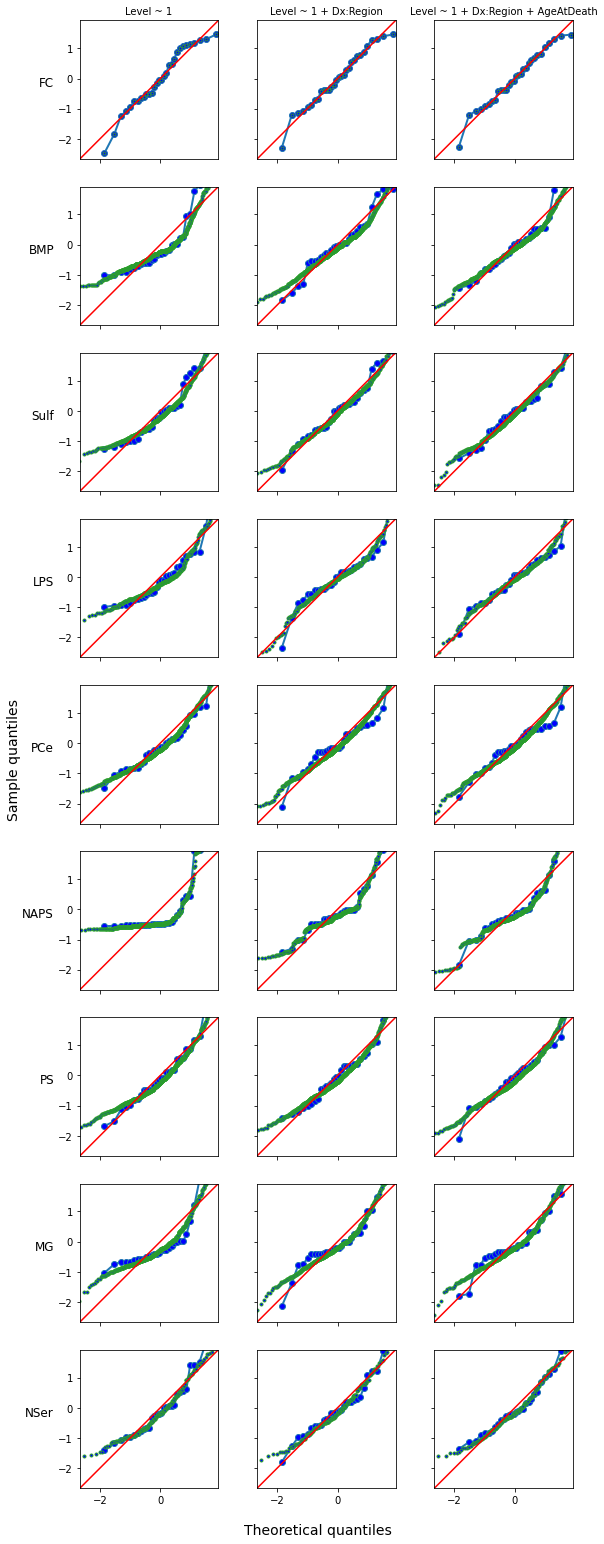

In [45]:
def qqplot_group(ax, group, effects='fixed', do_title=False):
    data = fitted_models[group].xs(effects, axis=0, level=0)
    gdata = fitted_groupmodels[group].xs(effects, axis=0, level=0)
    formulas = data.index[[0, 3, 4]]
    for formula, axi in zip(formulas, ax):
        m = data.loc[formula]
        gm = gdata.loc[formula]
        #sm.qqplot(m.resid, stats.norm, marker='.', ax=axi, line='45')
        sm.qqplot(gm.resid_pearson, stats.norm, marker='o', color='C0', ax=axi, linestyle='solid', linewidth=2)
        sm.qqplot(m.resid_pearson, stats.norm, marker='.', color='C2', ax=axi, line='45', linewidth=1)
        axi.set_xlabel('')
        axi.set_ylabel('')
        axi.set_aspect(1)
        if do_title:
            axi.set_title(formula, rotation=0, fontsize=10)
    ax[0].set_ylabel(group, rotation=0, fontsize=12, horizontalalignment='right')
    gline = Line2D([0, 1], [0, 0], linewidth=2, color='C0', label='group-level data', marker='o')
    line = Line2D([0, 1], [1, 1], linewidth=1, color='C2', label='species-level data', marker='.')
    return(ax)

sel_groups = ['FC', 'BMP', 'Sulf', 'LPS', 'PCe', 'NAPS', 'PS', 'MG', 'NSer']
fig, ax = plt.subplots(len(sel_groups), 3, figsize=(9, 3 * len(sel_groups)), sharey=True, sharex=True)
for g, axi in zip(sel_groups, ax):
    qqplot_group(axi, group=g, effects='fixed', do_title=True if g == 'FC' else False)
fig.supxlabel('Theoretical quantiles', y=0.1, fontsize=14)
fig.supylabel('Sample quantiles', fontsize=14)
attila_utils.savefig(fig, 'selected-qq-plots-fixed-fx')

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


['named-figure/all-qq-plots-fixed-fx.png',
 'named-figure/all-qq-plots-fixed-fx.pdf']

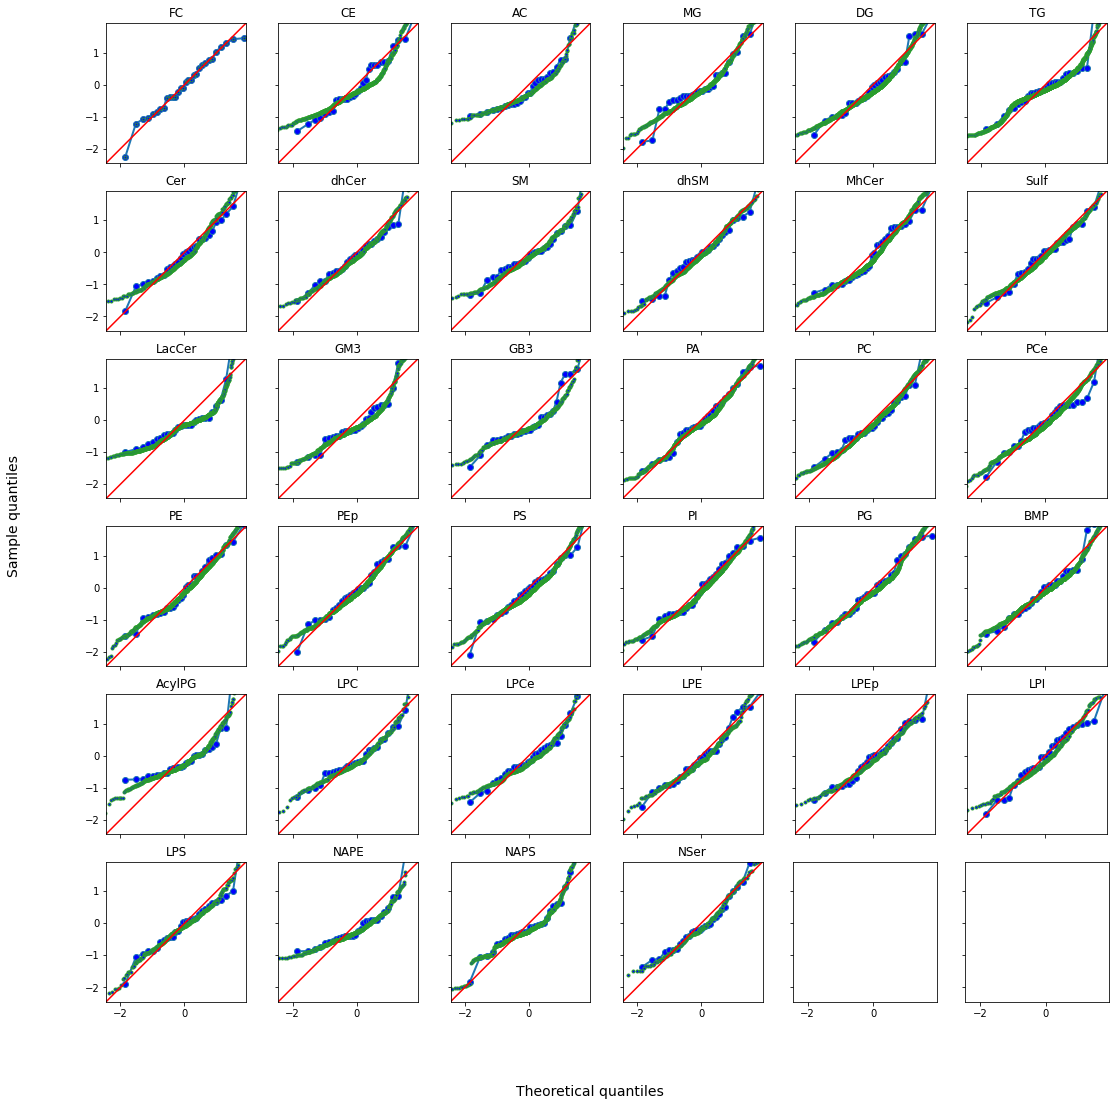

In [48]:
def qqplot_all_group(axi, group, effects='fixed'):
    data = fitted_models[group].xs(effects, axis=0, level=0)
    gdata = fitted_groupmodels[group].xs(effects, axis=0, level=0)
    formula = data.index[4]
    m = data.loc[formula]
    gm = gdata.loc[formula]
    #sm.qqplot(m.resid, stats.norm, marker='.', ax=axi, line='45')
    sm.qqplot(gm.resid_pearson, stats.norm, marker='o', color='C0', ax=axi, linestyle='solid', linewidth=2)
    sm.qqplot(m.resid_pearson, stats.norm, marker='.', color='C2', ax=axi, line='45', linewidth=1)
    axi.set_xlabel('')
    axi.set_ylabel('')
    axi.set_aspect(1)
    axi.set_title(group)
    #ax.set_ylabel(group, rotation=0, fontsize=12, horizontalalignment='right')
    gline = Line2D([0, 1], [0, 0], linewidth=2, color='C0', label='group-level data', marker='o')
    line = Line2D([0, 1], [1, 1], linewidth=1, color='C2', label='species-level data', marker='.')
    return(ax)

sel_groups = ['FC', 'BMP', 'Sulf', 'LPS', 'PCe', 'NAPS', 'PS', 'MG', 'NSer']


fig, ax = plt.subplots(6, 6, figsize=(18, 18), sharey=True, sharex=True)
for ix, group in zip(zip(*np.unravel_index(range(len(lipid_groups.index)), (6, 6))), lipid_groups.index):
    axi = ax[ix]
    qqplot_all_group(axi, group=group, effects='fixed')

fig.supxlabel('Theoretical quantiles', y=0.05, fontsize=14)
fig.supylabel('Sample quantiles', x=0.05, fontsize=14)
attila_utils.savefig(fig, 'all-qq-plots-fixed-fx')

In [47]:
%connect_info

{
  "shell_port": 51393,
  "iopub_port": 51394,
  "stdin_port": 51395,
  "control_port": 51397,
  "hb_port": 51396,
  "ip": "127.0.0.1",
  "key": "51d06249-f8bf47a2263606bf04d3e7f1",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-2f9d002f-100c-4eea-a2be-ba5cdf4db544.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
